# Triple MNIST recognition using CNN

The model predicts 3-digit numbers written on the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

My solution contains:
- Digit cropper (opencv). By cropping the digits from images, I deduced the triple MNIST problem into simple MNIST
- Custom PyTorch DataLoader implementation
- Image augmentations
- CNN model for digits classification
- Automated fine-tuning of the model architecture. You can specify value ranges and run Optuna trials for the following hyperparameters: number of layers, number of filters, activation function, learning rate, momentum, regularization


In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import optuna
from optuna.samplers import TPESampler
import os
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import cv2
from typing import Tuple, NamedTuple, List
from tqdm import tqdm
import time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import graphviz

RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOG_INTERVAL = 100
optuna.logging.set_verbosity(optuna.logging.INFO)

### Model

### Data processing

In [55]:
CLASSES = [digit for digit in range(10)]
NUM_CLASSES = len(CLASSES)
NUM_DIGITS = 3

#### Digits Segmentation

In [56]:
DIGIT_WIDTH_HEIGHT = 28
digit_shape = (DIGIT_WIDTH_HEIGHT, DIGIT_WIDTH_HEIGHT)

def crop_digits(img_path: str = None, im = None):
    if im is None:
        im = cv2.imread(img_path)

    # transform the image
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(blur, 90, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    digits = []
    rect = im.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # increase the borders a bit
        x = max(x - 3, 0)
        y = max(y - 3, 0)
        w += 6
        h += 6

        del_x = int(w / 2)
        del_y = int(h / 2)
        center_x = x + del_x
        center_y = y + del_y

        lu_corner = (max(center_x - del_y, 0), y)
        rd_corner = (max(center_x + del_y, 0), y + h)

        # Drawing a rectangle on copied image
        rect = cv2.rectangle(rect, lu_corner, rd_corner, (255, 0, 0), 2)

        cropped = im[lu_corner[1]:rd_corner[1], lu_corner[0]:rd_corner[0]]
        digits.append(cropped)

    def filter_and_sort_digits(digits, contours):
        # returns only actual digits from the digits list
        # returns 3 digits with the number of pixels closest to the average
        sizes = []
        for digit in digits:
            size = digit.shape[0] * digit.shape[1]
            sizes.append(size)
        avg_size = sum(sizes) / len(sizes)
        deviations = [abs(size - avg_size) for size in sizes]

        indices = np.argsort(deviations)[0:3]
        digits = [digits[i] for i in indices]
        contours = [cv2.boundingRect(contours[i]) for i in indices]

        # sort by contour coordinate x
        xs = [contour[0] for contour in contours]
        indices = np.argsort(xs)
        digits = [digits[i] for i in indices]

        while len(digits) < NUM_DIGITS:
            digits.append(digits[0])
        return digits

    digits = filter_and_sort_digits(digits, contours)
    # resize each digit
    digits = [cv2.resize(digit, digit_shape, interpolation = cv2.INTER_NEAREST) for digit in digits]

    return digits, contours, rect

Display image and label:

Label: 118
crop shape: (28, 28, 3)
crop shape: (28, 28, 3)
crop shape: (28, 28, 3)


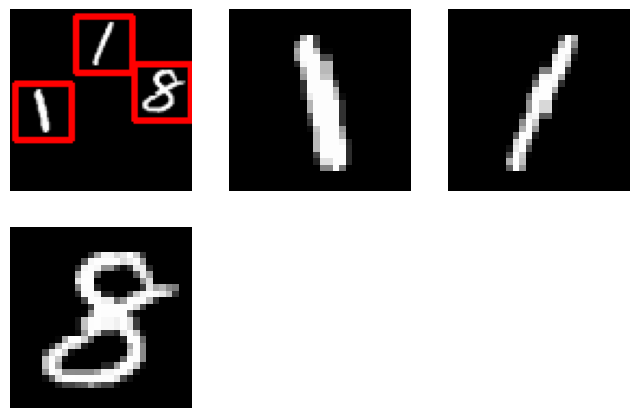

Label: 118
crop shape: (28, 28, 3)
crop shape: (28, 28, 3)
crop shape: (28, 28, 3)


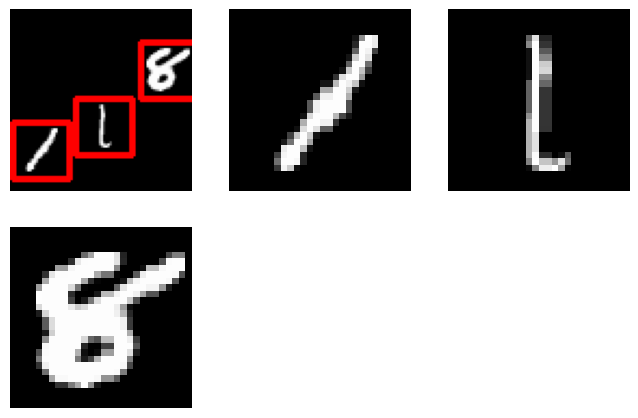

In [57]:
dir_path = "triple_mnist/train/118"
for filename in os.listdir(dir_path)[0:2]:
    img_path = os.path.join(dir_path, filename)

    label = filename.split('_', maxsplit=1)[1].split('.', maxsplit=1)[0]
    print(f"Label: {label}")

    fig = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3

    digits, contours, rect = crop_digits(img_path)

    fig.add_subplot(rows, cols, 1)
    plt.axis("off")
    plt.imshow(rect.squeeze())
    for i in range(len(digits)):
        img = digits[i]
        fig.add_subplot(rows, cols, i+2)
        plt.axis("off")
        plt.imshow(img.squeeze())
        print(f"crop shape: {img.shape}")
    plt.show()

#### Data Loading

Custom Data Loader for Triple MNIST:

In [58]:
class TripleMnistDataset(Dataset):
    def __init__(self, img_dir, transform=None, table=None):
        self.img_dir = img_dir
        self.transform = transform

        if table:
            self.table = table
        else:
            self.table = self.fill_table()

    def fill_table(self):
        table = {}
        idx = 0

        for subdir in os.listdir(self.img_dir):
            subdir_path = os.path.join(self.img_dir, subdir)
            for img_filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, img_filename)
                labels = self.get_label(img_filename)

                table[idx] = (img_path, labels)
                idx += 1
        return table

    def __len__(self):
        return sum([len(files) for _, _, files in os.walk(self.img_dir)])

    def get_label(self, filename: str):
        return [int(digit) for digit in filename.split('_', maxsplit=1)[1].split('.', maxsplit=1)[0]]

    def __getitem__(self, idx):
        img_path, labels = self.table[idx]
        digits, _, _ = crop_digits(img_path)
        if self.transform:
            digits = [self.transform(digit) for digit in digits]
        return digits, labels

In [59]:
batch_size = 64
test_batch_size = 20000

triple_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081)),
])

triple_train_data = TripleMnistDataset(img_dir="triple_mnist/train", transform=triple_transforms)
triple_val_data = TripleMnistDataset(img_dir="triple_mnist/val", transform=triple_transforms)
triple_test_data = TripleMnistDataset(img_dir="triple_mnist/test", transform=triple_transforms)

triple_train_loader = DataLoader(triple_train_data, batch_size=batch_size, shuffle=True)
triple_val_loader = DataLoader(triple_val_data, batch_size=test_batch_size, shuffle=True)
triple_test_loader = DataLoader(triple_test_data, batch_size=test_batch_size, shuffle=True)

print(f"Train dataset size: {len(triple_train_data)}")
print(f"Validation dataset size: {len(triple_val_data)}")
print(f"Test dataset size: {len(triple_test_data)}")

Train dataset size: 64000
Validation dataset size: 16000
Test dataset size: 20000


Digit shape: torch.Size([64, 1, 28, 28])
Digit type: <class 'torch.Tensor'>
Target len: 64
Target type: <class 'torch.Tensor'>

Digit at position 1


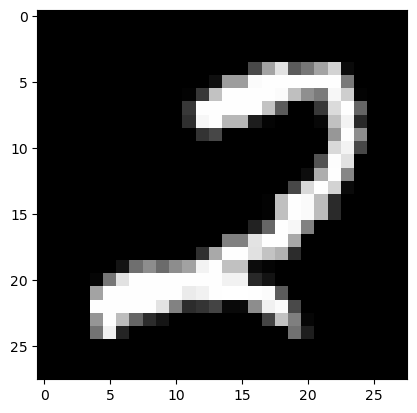

Label: 2
Digit at position 2


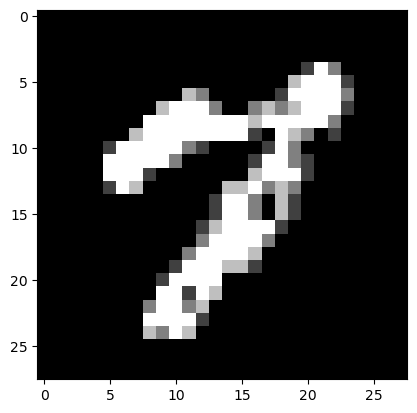

Label: 7
Digit at position 3


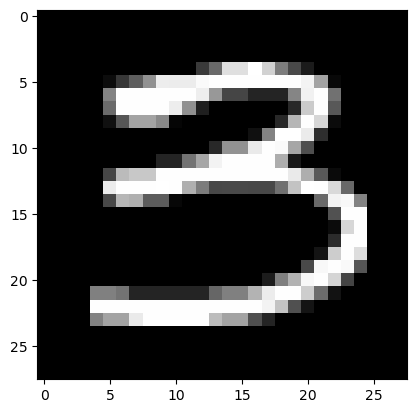

Label: 3


In [60]:
# display image and label
b_idx = 1
train_features, train_labels = next(iter(triple_train_loader))

print(f"Digit shape: {train_features[0].shape}")
print(f"Digit type: {type(train_features[0])}")
print(f"Target len: {len(train_labels[0])}")
print(f"Target type: {type(train_labels[0])}\n")

for digit_idx in range(3):
    print(f"Digit at position {digit_idx + 1}")
    im = train_features[digit_idx][b_idx]
    label = train_labels[digit_idx][b_idx]
    im = im.squeeze()
    plt.imshow(im, cmap="gray")
    plt.show()
    print(f"Label: {label}")

### Original MNIST Data Loading & Augmentation

I tried to train my CNN with custom data loader implemented above, however it took 1 hour for 1 epoch. This is due to the digits cropping operations performed for each image.

So, in order to train my CNN, I needed to get the dataset with digits only. I could construct it from the triple MNIST dataset, however it would take a lot of effort (it's my first experience with PyTorch). The simpler way is to train the CNN on the original MNIST dataset. It is not prohibited by the assignment specs, yet fits common sense: the digits itself are identical in both datasets.

In [70]:
batch_size = 128
test_batch_size = 512

mnist_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

mnist_train = datasets.MNIST('mnist', train=True, transform=mnist_transforms, download=True)
mnist_train_50, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])
mnist_test = datasets.MNIST('mnist', train=False, transform=mnist_transforms)

mnist_train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
mnist_train_50_loader = DataLoader(mnist_train_50, batch_size=batch_size, shuffle=True)
mnist_val_loader = DataLoader(mnist_val, batch_size=test_batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=True)

In [71]:
len(mnist_train)

60000

### Model

In [63]:
class ConvLayer(NamedTuple):
    in_channels: int
    out_channels: int
    kernel_size: int
    padding: int
    stride: int
    dilation: int
    activation: str
    maxpool_kernel_size: int = None
    dropout_proba: float = None
    in_size: int = None


def get_out_size_conv2d(in_size: int, padding: int, dilation: int, kernel_size: int, stride: int):
    return int(np.floor((in_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))


def get_out_size_pool(in_size: int, kernel_size: int, padding: int = 0, dilation: int = 1, stride: int = 2):
    return int(np.floor((in_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))


def get_out_size(conv: ConvLayer):
    out_size = get_out_size_conv2d(conv.in_size, conv.padding, conv.dilation, conv.kernel_size, conv.stride)
    if conv.maxpool_kernel_size:
        out_size = get_out_size_pool(out_size, conv.maxpool_kernel_size)
    return out_size

In [64]:
class CNN(nn.Module):
    def __init__(self,
                 conv_layers: List[ConvLayer],
                 n_output: int = 10):
        super(CNN, self).__init__()

        layers = []
        for i in range(len(conv_layers)):
            if not conv_layers[i].in_size:
                conv_layers[i] = conv_layers[i]._replace(in_size=get_out_size(conv_layers[i-1]))
            conv_layer = conv_layers[i]
            conv = nn.Conv2d(
                conv_layer.in_channels,
                conv_layer.out_channels,
                conv_layer.kernel_size,
                conv_layer.stride,
                conv_layer.padding,
                conv_layer.dilation,
            )
            layers.append(conv)
            bn = nn.BatchNorm2d(conv_layer.out_channels)
            layers.append(bn)
            activation = getattr(nn, conv_layer.activation)()
            layers.append(activation)
            if conv_layer.maxpool_kernel_size:
                maxpool = nn.MaxPool2d(conv_layer.maxpool_kernel_size, stride=2)
                layers.append(maxpool)
            if conv_layer.dropout_proba:
                dropout = nn.Dropout(conv_layer.dropout_proba)
                layers.append(dropout)

        self.extractor = torch.nn.Sequential(*layers)

        n_input = get_out_size(conv_layers[-1])
        print(conv_layers[-1].maxpool_kernel_size)
        print(f"n_input: {n_input}")
        self.linear = nn.Linear(conv_layers[-1].out_channels * n_input ** 2, n_output)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feature_map = self.extractor(x)
        feature_vector = torch.flatten(feature_map, 1)
        return self.linear(feature_vector)

In [65]:
def train_epoch_2(
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        loader: torch.utils.data.DataLoader,
        criterion: torch.nn.modules.loss._Loss,
        device: torch.device,
        verbose: bool = False,
) -> float:
    model.train()
    optimizer.zero_grad()

    accum_loss = 0
    total = len(loader.dataset)
    if verbose:
        loader = tqdm(loader, desc="Training", total=len(loader), leave=True)
    for input_data, target in loader:
        input_data = input_data.to(device)
        target = target.to(device)

        predicted = model(input_data)

        loss = criterion(predicted, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accum_loss += loss.item()

    return accum_loss / total

In [66]:
def eval_epoch_2(
        model: torch.nn.Module,
        loader: torch.utils.data.DataLoader,
        criterion: torch.nn.modules.loss._Loss,
        device: torch.device,
        verbose: bool = False,
) -> Tuple:
    model.eval()

    accum_loss = 0
    acc = 0

    total = len(loader.dataset)
    with torch.no_grad():
        if verbose:
            loader = tqdm(loader, desc="Evaluation", total=len(loader), leave=True)
        for input_data, target in loader:
            input_data = input_data.to(device)
            target = target.to(device)

            predicted = model(input_data)

            loss = criterion(predicted, target)
            accum_loss += loss.item()

            acc += torch.sum(
                torch.argmax(predicted, 1) == target
            ).item()

    loss = accum_loss / total
    accuracy = acc / total
    return loss, accuracy

In [67]:
def train_2(
        num_epochs: int,
        model: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler,
        train_loader: torch.utils.data.DataLoader,
        test_loader: torch.utils.data.DataLoader,
        criterion: torch.nn.modules.loss._Loss,
        device: torch.device
) -> Tuple:

    train_loss = []
    val_loss = []
    val_acc = []
    for epoch in range(num_epochs):
        loss = train_epoch_2(
            model, optimizer, train_loader, criterion, device, verbose=True
        )
        train_loss.append(loss)
        eval_loss, eval_accuracy = eval_epoch_2(
            model, test_loader, criterion, device, verbose=True
        )
        val_loss.append(eval_loss)
        val_acc.append(eval_accuracy)

        scheduler.step()

        print(f"Epoch #{epoch}:")
        print(f"Training Loss: {loss}")
        print(f"Evaluation Loss: {eval_loss}")
        print(f"Accuracy: {eval_accuracy}")
    return train_loss, val_loss, val_acc

In [70]:
conv_layers = [
    ConvLayer(in_channels=1, out_channels=16, kernel_size=6, padding=0, stride=1, dilation=1,
              activation="ReLU", in_size=DIGIT_WIDTH_HEIGHT),
    ConvLayer(in_channels=16, out_channels=32, kernel_size=5, padding=0, stride=1, dilation=1,
              activation="ReLU"),
    ConvLayer(in_channels=32, out_channels=64, kernel_size=3, padding=0, stride=1, dilation=1,
              activation="LeakyReLU"),
    ConvLayer(in_channels=64, out_channels=64, kernel_size=3, padding=0, stride=1, dilation=1,
              activation="LeakyReLU", maxpool_kernel_size=2, dropout_proba=0.2),
]

model_2 = CNN(conv_layers, NUM_CLASSES).to(DEVICE)
print(model_2)

optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.7, nesterov=True, weight_decay=0.0001)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=2, gamma=0.05)

criterion_2 = torch.nn.CrossEntropyLoss()

2
n_input: 7
CNN(
  (extractor): Sequential(
    (0): Conv2d(1, 16, kernel_size=(6, 6), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.2, inplace=False)
  )
  (linear): Linear(in_features=3136, out_features=10, bias=True)
)


In [71]:
num_epochs = 2

training_results_2 = train_2(
    num_epochs,
    model_2,
    optimizer_2,
    scheduler_2,
    mnist_train_loader,
    mnist_test_loader,
    criterion_2,
    DEVICE
)

Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.04it/s]


Epoch #0:
Training Loss: 0.004693997601171334
Evaluation Loss: 0.0006030243456363678
Accuracy: 0.9099


Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.12it/s]

Epoch #1:
Training Loss: 0.0024076845402518907
Evaluation Loss: 0.00046825811713933945
Accuracy: 0.9284


### Fine-tuning

In [103]:
def define_model_2_trial(trial):
    n_conv_layers = trial.suggest_int("n_conv_layers", 2, 6)
    conv_layers = []

    in_channels = 1
    for i in range(n_conv_layers):
        if i == 0:
            in_size = DIGIT_WIDTH_HEIGHT

            out_channels_lim = in_channels * 24

            kernel_size = trial.suggest_int(f"kernel_size_cl{i}", 3, int(DIGIT_WIDTH_HEIGHT / 3))

            maxpool_kernel_size = None

        else:
            in_size = get_out_size(conv_layers[i-1])

            out_channels_lim = in_channels * 3

            try:
                kernel_size = trial.suggest_int(f"kernel_size_cl{i}", 2, min(kernel_size, int(in_size / 3)))
            except ValueError as e:
                print(e)
                break

        padding = trial.suggest_int(f"padding_cl{i}", 0, 2)

        stride_dilation_lim = max(
            min(3, int(in_size / (kernel_size * 3))),
            min(2, int(in_size / (kernel_size * 2)))
        )
        dilation = trial.suggest_int(f"dilation_cl{i}", 1, stride_dilation_lim)
        stride = trial.suggest_int(f"stride_cl{i}", 1, stride_dilation_lim)

        if i > 0:
            in_size_ = get_out_size_conv2d(in_size=in_size, padding=padding, dilation=dilation, kernel_size=kernel_size, stride=stride)
            maxpool_kernel_size_lim = in_size_ // 2
            maxpool_kernel_size_lim = 1 if maxpool_kernel_size_lim < 1 else maxpool_kernel_size_lim
            maxpool_kernel_size = trial.suggest_int(f"maxpool_kernel_size_cl{i}", 1, maxpool_kernel_size_lim)
            while get_out_size_pool(in_size_, maxpool_kernel_size) < 2 and maxpool_kernel_size > 1:
                maxpool_kernel_size -= 1
            maxpool_kernel_size = None if maxpool_kernel_size == 1 else maxpool_kernel_size

        out_channels = trial.suggest_int(f"out_channels_cl{i}", in_channels, out_channels_lim)

        activation_name = trial.suggest_categorical(f"activation_cl{i}", ["ReLU", "LeakyReLU"])

        dropout_proba = trial.suggest_uniform("dropout_cl{}".format(i), 0, 0.5)

        conv_layer = ConvLayer(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation, activation=activation_name, maxpool_kernel_size=maxpool_kernel_size, dropout_proba=dropout_proba, in_size=in_size)
        conv_layers.append(conv_layer)

        in_channels = out_channels

    return CNN(conv_layers, NUM_CLASSES)

In [104]:
def objective_2(trial):
    # generate the model
    model = define_model_2_trial(trial).to(DEVICE)
    print(model)

    # optimizer parameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    momentum = trial.suggest_uniform("momentum", 0.4, 0.999)
    nesterov = trial.suggest_int("nesterov", 0, 1)
    weight_decay = trial.suggest_uniform("weight_decay", 0, 1e-3)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov, weight_decay=weight_decay)

    # lr scheduler parameters
    step_size = trial.suggest_int("step_size", 1, 2)
    gamma = trial.suggest_uniform("gamma", 0.01, 0.9)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}...")
        train_loss = train_epoch_2(model, optimizer, mnist_train_50_loader, criterion_2, DEVICE, verbose=True)
        val_loss, val_accuracy = eval_epoch_2(model, mnist_val_loader, criterion_2, DEVICE, verbose=True)
        scheduler.step()
        print(f"Accuracy on val set: {val_accuracy}")

    return val_loss

In [ ]:
def print_study_stats(study):
    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

In [ ]:
sampler_2  = TPESampler(seed=RANDOM_STATE)
pruner_2 = optuna.pruners.MedianPruner()
study_2 = optuna.create_study(direction="minimize", sampler=sampler_2, pruner=pruner_2)

num_epochs = 4
print("Study in process...")
study_2.optimize(objective_2, n_trials=250)

print_study_stats(study_2)

In [74]:
conv_layers = [
    ConvLayer(in_channels=1, out_channels=23, kernel_size=3, padding=0, stride=2, dilation=3,
              activation="ReLU", in_size=DIGIT_WIDTH_HEIGHT, dropout_proba=0.2048),
    ConvLayer(in_channels=23, out_channels=58, kernel_size=3, padding=1, stride=1, dilation=1,
              activation="LeakyReLU", dropout_proba=0.2316),
    ConvLayer(in_channels=58, out_channels=112, kernel_size=3, padding=0, stride=1, dilation=1,
              activation="LeakyReLU", dropout_proba=0.2316),
    ConvLayer(in_channels=112, out_channels=286, kernel_size=3, padding=0, stride=1, dilation=1,
              activation="LeakyReLU", dropout_proba=0.1488),
    ConvLayer(in_channels=286, out_channels=563, kernel_size=2, padding=0, stride=1, dilation=1,
              activation="ReLU", dropout_proba=0.0031),
]

model_2 = CNN(conv_layers, NUM_CLASSES).to(DEVICE)
print(model_2)

optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.002208, momentum=0.965797, nesterov=False, weight_decay=5.376853e-05)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=2, gamma=0.13916)

criterion_2 = torch.nn.CrossEntropyLoss()

None
n_input: 6
CNN(
  (extractor): Sequential(
    (0): Conv2d(1, 23, kernel_size=(3, 3), stride=(2, 2), dilation=(3, 3))
    (1): BatchNorm2d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2048, inplace=False)
    (4): Conv2d(23, 58, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2316, inplace=False)
    (8): Conv2d(58, 112, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.2316, inplace=False)
    (12): Conv2d(112, 286, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(286, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.1488, inplace=False)
    (16): Con

In [76]:
num_epochs = 5

training_results_2 = train_2(
    num_epochs,
    model_2,
    optimizer_2,
    scheduler_2,
    mnist_train_loader,
    mnist_test_loader,
    criterion_2,
    DEVICE
)

Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch #0:
Training Loss: 0.0037938996771971385
Evaluation Loss: 0.0005451065093278885
Accuracy: 0.9204


Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


Epoch #1:
Training Loss: 0.0028100369859486818
Evaluation Loss: 0.00043098950386047364
Accuracy: 0.9374


Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.32it/s]


Epoch #2:
Training Loss: 0.0017546434544026851
Evaluation Loss: 0.00027455561831593513
Accuracy: 0.9545


Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Epoch #3:
Training Loss: 0.0015312805471320947
Evaluation Loss: 0.0002608620226383209
Accuracy: 0.9573


Evaluation: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]

Epoch #4:
Training Loss: 0.0014566465949639679
Evaluation Loss: 0.00025730386078357697
Accuracy: 0.959


### Triple MNIST prediction

In [68]:
def test_triple(
        model: torch.nn.Module,
        num_digits: int,
        loader: torch.utils.data.DataLoader,
        criterion: torch.nn.modules.loss._Loss,
        device: torch.device,
        verbose: bool = False,
) -> Tuple:
    model.eval()

    accum_loss = 0
    acc = 0
    per_digit_ctr = torch.tensor([0.] * 10).to(device)
    per_digit_acc = torch.tensor([0.] * 10).to(device)

    total = len(loader.dataset)
    with torch.no_grad():
        if verbose:
            loader = tqdm(loader, desc="Evaluation", total=None, leave=True)
        for input_data_list, target_list in loader:
            # construct the 3-digit prediction
            matches = None
            for num_digit in range(num_digits):
                input_data = input_data_list[num_digit]
                input_data = input_data.to(device)
                target = target_list[num_digit]
                target = target.to(device)

                predictions = model(input_data)

                if matches is None:
                    matches = torch.tensor([True] * len(target)).to(device)
                matches *= torch.argmax(predictions, 1) == target

                per_digit_correct_idx = target[torch.flatten(torch.nonzero(matches))]
                n_examples = torch.tensor([1.] * len(target)).to(device)
                per_digit_ctr.index_add_(dim=0, index=target, source=n_examples)
                n_corrects = torch.tensor([1.] * len(per_digit_correct_idx)).to(device)
                per_digit_acc.index_add_(dim=0, index=per_digit_correct_idx, source=n_corrects)

            # modify the metrics variables according to the last prediction
            acc += sum(matches).item()

            loss = criterion(predictions, target)
            accum_loss += loss.item()

    loss = accum_loss / total
    accuracy = acc / total
    num_predicted_digits = (total * num_digits)
    one_digit_accuracy = sum(per_digit_acc).item() / num_predicted_digits
    per_digit_accuracies = per_digit_acc / per_digit_ctr

    return loss, accuracy, one_digit_accuracy, per_digit_accuracies

In [78]:
triple_loss, triple_accuracy, triple_one_digit_accuracy, triple_per_digit_accuracies =\
    test_triple(
        model_2,
        NUM_DIGITS,
        triple_test_loader,
        criterion_2,
        DEVICE,
        verbose=True
    )

print(f'\rTriple MNIST test set average Cross Entropy Loss: {triple_loss:.7f}')
print(f'\rTriple MNIST test set Accuracy: {triple_accuracy:.4f}')
print(f'\rTriple MNIST test set one-digit Accuracy: {triple_one_digit_accuracy:.4f}')
print(f'\rTriple MNIST test set per-digit Accuracies:\n{triple_per_digit_accuracies}')

Evaluation: 100%|██████████| 1/1 [00:15<00:00, 15.33s/it]

Triple MNIST test set average Cross Entropy Loss: 0.0000043
Triple MNIST test set Accuracy: 0.9413
Triple MNIST test set one-digit Accuracy: 0.9599
Triple MNIST test set per-digit Accuracies:
tensor([0.9727, 0.9716, 0.9594, 0.9634, 0.9486, 0.9567, 0.9623, 0.9622, 0.9603,
        0.9428], device='cuda:0')
